# Time Series Playgroound

The next code block will set up data generation helpers for the time series with seasonality, trend, autocorrelation and a bit of noise.

[Introduction notebook](https://github.com/lmoroney/dlaicourse/blob/master/TensorFlow%20In%20Practice/Course%204%20-%20S%2BP/S%2BP%20Week%201%20-%20Lesson%201%20-%20Notebook.ipynb)
[colab](https://colab.research.google.com/github/lmoroney/dlaicourse/blob/master/TensorFlow%20In%20Practice/Course%204%20-%20S%2BP/S%2BP_Week_1_Lesson_2.ipynb)

[Forecasting notebook](https://github.com/lmoroney/dlaicourse/blob/master/TensorFlow%20In%20Practice/Course%204%20-%20S%2BP/S%2BP%20Week%201%20-%20Lesson%203%20-%20Notebook.ipynb) [colab](https://colab.research.google.com/github/lmoroney/dlaicourse/blob/master/TensorFlow%20In%20Practice/Course%204%20-%20S%2BP/S%2BP%20Week%201%20-%20Lesson%203%20-%20Notebook.ipynb)


In [27]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    "white noise"
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level
    
def impulses(time, num_impulses, amplitude=1, seed=None):
    """impulse noise"""
    rnd = np.random.RandomState(seed)
    impulse_indices = rnd.randint(len(time), size=10)
    series = np.zeros(len(time))
    for index in impulse_indices:
        series[index] += rnd.rand() * amplitude
    return series

def autocorrelation1(time, amplitude):
    rho = 0.8 # ϕ
    ar = np.random.randn(len(time) + 1)
    for step in range(1, len(time) + 1):
        ar[step] += rho * ar[step - 1]
    return ar[1:] * amplitude

def autocorrelation2(time, amplitude):
    rho1 = 0.5  # ϕ1
    rho2 = -0.1 # ϕ2
    ar = np.random.randn(len(time) + 50)
    ar[:50] = 100
    for step in range(50, len(time) + 50):
        ar[step] += rho1 * ar[step - 50]
        ar[step] += rho2 * ar[step - 33]
    return ar[50:] * amplitude

def autocorrelation3(source, φs):
    ar = source.copy()
    max_lag = len(φs)
    for step, value in enumerate(source):
        for lag, φ in φs.items():
            if step - lag > 0:
              ar[step] += φ * ar[step - lag]
    return ar


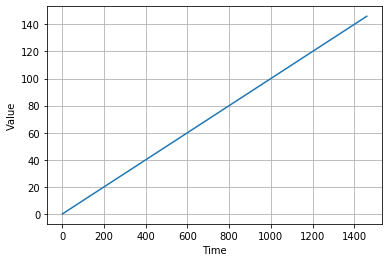

In [2]:
time = np.arange(4 * 365 + 1)
s = trend(time, 0.1)
plot_series(time, s)

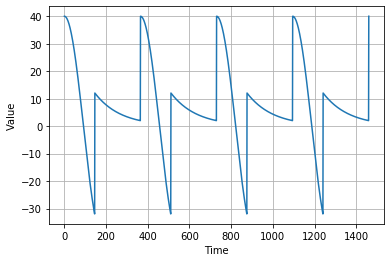

In [3]:
s = seasonality(time, period=365, amplitude = 40)
plot_series(time, s)

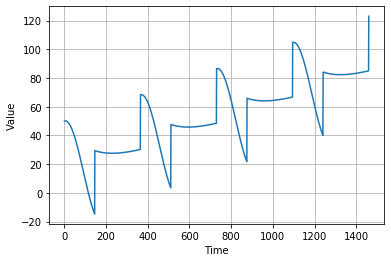

In [4]:
baseline = 10
s = baseline + trend(time, slope=0.05) + seasonality(time, period=365, amplitude = 40)
plot_series(time, s)

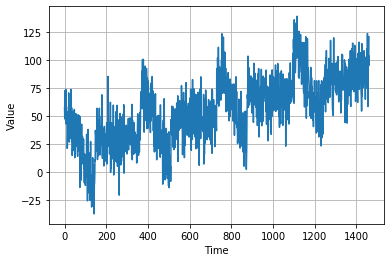

In [5]:
noisy_s = s + noise(time, noise_level=15, seed=42)
plot_series(time, noisy_s)

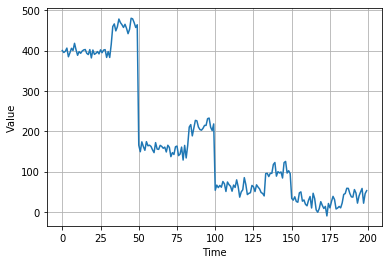

In [7]:
# trivial autocorrelation
plot_series(time, autocorrelation2(time, 10), end=200 )

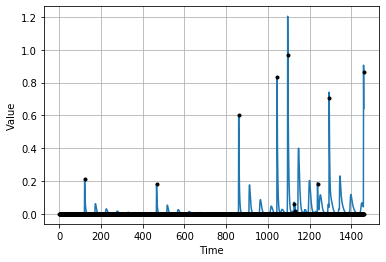

In [18]:
# autocorrelation with hidden trigger signal

signal = impulses(time, 10, seed=42)
series = autocorrelation3(signal, {1: 0.70, 50: 0.2})
plot_series(time, series)
# signal in blak
plt.plot(time, signal, "k.")


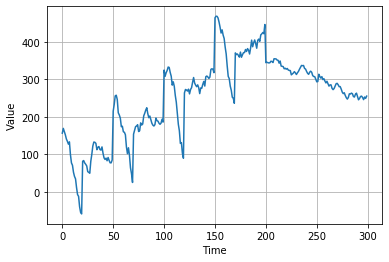

In [23]:
# more realistic mix with autocorrelation
s = autocorrelation1(time, amplitude=10) + seasonality(time, period=50, amplitude=150) + trend(time, 2)
s2 = autocorrelation1(time, amplitude=5 ) + seasonality(time, period=50, amplitude=2  ) + trend(time, -1) + 550
s[200:] = s2[200:]
plot_series(time, s, end=300)

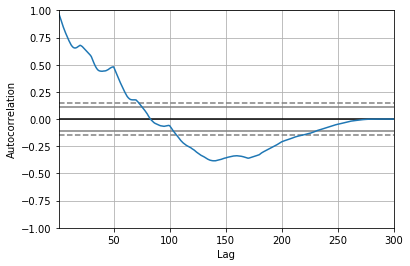

In [26]:
# Correlogram 
"""
Autocorrelation plots are often used for checking randomness in time series. This is done by computing autocorrelations for data values 
at varying time lags. If time series is random, such autocorrelations should be near zero for any and all time-lag separations. 
If time series is non-random then one or more of the autocorrelations will be significantly non-zero. 
The horizontal lines displayed in the plot correspond to 95% and 99% confidence bands. The dashed line is 99% confidence band. 

https://en.wikipedia.org/wiki/Correlogram
"""
from pandas.plotting import autocorrelation_plot

autocorrelation_plot(s[:300])
# note high confidence in autocorrelation with small lag